---
# How to use [ParseEyetrackerFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseEyetrackerFile)

This notebook illustrates how to read in the output from the `EyeLink`-software, as implemented with [exptools](https://github.com/Gilles86/exptools2/tree/show_pupil).

In [10]:
%matplotlib inline

In [2]:
# imports
from linescanning import (
    dataset, 
    plotting, 
    fitting
    )

import os
opj = os.path.join
opd = os.path.dirname

221207-14:58:37,988 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.2


Whenever you run an experiment with [exptools](https://github.com/Gilles86/exptools2/tree/show_pupil), you'll get an `edf`-file. This file can be read in with [hedfpy](https://github.com/gjheij/hedfpy), which is wrapped into the [ParseEyetrackerFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseEyetrackerFile)-class within the `linescanning`-toolbox. I have provided an example dataset `eye.edf`. This is from a recent 3D-EPI acquisition with a TR of 1.1s, and 270 volumes (this is necessary to extract the correct time period of the eyetracking)

In [3]:
# define an edf file
edf_file = opj(opd(opd(dataset.__file__)), 'examples', 'eye.edf')

The hard part is actually *getting* the eyetracking data, processing is not that difficult really. We can just plop everything in the class and check it's read-outs, but first let's try to understand what happens under the hood.

From [hedfpy](https://github.com/gjheij/hedfpy):

"*For full parsing of the edf file data, hedfpy assumes a specific trial-based experimental format that is communicated to the eye tracker. Specifically, it looks for explicitly formatted messages by means of regular expressions. These messages detail the start and end of trial phases, trials, button press events, sound events and the stimulus parameters for a given trial which are all stored in tabular format in the HDF5 file. The parsing of these messages can be turned off for basic functionality.*". This `hdf5`-file is stored in the directory in which `edf_file` lives. It will also store other outputs - such as basic quality assessments - in that folder.

The way the line-scanning toolbox is reading in data is as follows:

- Either use specific classes as stand-alone (e.g., [ParseEyetrackerFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseEyetrackerFile), or [ParseExpToolsFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseExpToolsFile))
- Combine eyetracker and exptools file (in case of psychophysical experiments) with [ParseExpToolsFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseExpToolsFile)
- Combine eyetracker, exptools, and functional files with [ParseFuncFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseFuncFile) or the [dataset](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.Dataset)-class

In any case, it's best to use `use_bids=True`, as this will read subject/session/run-specific information from the file itself. If you've done the same for your functional files, every dataframe that comes out of this lines up index-wise, which is great (and which is why it's default!). Because our `edf-file` is called `eye.edf`, I'll turn off `use_bids`.

Let's see how that looks:

## Stand-alone usage

In [4]:
nr_vols = 270
TR = 1.1

eye_ = dataset.ParseEyetrackerFile(
    edf_file,
    use_bids=False,
    verbose=True,
    nr_vols=270,
    TR=TR
)

I was able to import hedfpy

EYETRACKER
22-12-07_14-58-39 - INFO - EDFOperator - started with eye.edf
22-12-07_14-58-39 - INFO - EDF2ASCOperator - <hedfpy.CommandLineOperator.EDF2ASCOperator object at 0x7f1e2c01d760> initialized with file eye.edf
22-12-07_14-58-39 - DEBUG - EDF2ASCOperator - <hedfpy.CommandLineOperator.EDF2ASCOperator object at 0x7f1e2c01d760>executing command 
edf2asc -t -ftime -y -z -v -s -miss 0.0001 -vel "/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.edf"; mv "/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.asc" "/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.gaz"; edf2asc -t -ftime -y -z -v -e "/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.edf"; mv "/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.asc" "/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.msg"
22-12-07_14-58-42 - INFO - EDFOper

Ideally, this does not return an error. If so, we can inspect some of the parameters it extracted from the file (see the list after `Fetching` above)

In [5]:
# we get a dataframe for blink onsets
eye_.df_blinks.head()

onset
subject run event_type        
1       1   blink        3.298
            blink       11.899
            blink       17.987
            blink       31.194
            blink       43.787

In [6]:
# and gaze/pupil size both in eyetracking time (@sample rate)
eye_.df_space_eye.head()

pupil  pupil_int  gaze_x_int  gaze_y_int      gaze_x  \
subject run t                                                              
1       1   0.000  3634.0     3634.0  864.299988  542.000000  864.299988   
            0.001  3627.0     3627.0  871.200012  511.899994  871.200012   
            0.002  3679.0     3679.0  866.500000  519.900024  866.500000   
            0.003  3630.0     3630.0  865.400024  538.099976  865.400024   
            0.004  3686.0     3686.0  856.900024  517.700012  856.900024   

                       gaze_y  
subject run t                  
1       1   0.000  542.000000  
            0.001  511.899994  
            0.002  519.900024  
            0.003  538.099976  
            0.004  517.700012

In [7]:
# or resampled to the TR (useful for deconvolution of eyeblinks) > also has high-pass/percent signal changed versions. This takes too long for the data @sample_rate
eye_.df_space_func.head()

pupil     pupil_hp  pupil_psc  pupil_hp_psc  pupil_int  \
subject run t                                                              
1       1   0.0  3634.0  3306.871094  29.478714     17.873978     3634.0   
            1.1  2884.0  2557.087891   2.614754     -8.982216     2884.0   
            2.2  3193.0  2866.520752  13.682709      2.101234     3193.0   
            3.3  3087.0  2761.168213   9.885933     -1.672340     3087.0   
            4.4  2697.0  2372.028076  -4.083328    -15.610802     2697.0   

                 pupil_int_hp  pupil_int_psc  pupil_int_hp_psc  gaze_x_int  \
subject run t                                                                
1       1   0.0   3301.236572      29.483154         17.548630  864.299988   
            1.1   2551.462402       2.615150         -9.311279  923.000000   
            2.2   2860.913330      13.684769          1.774490  932.799988   
            3.3   2755.588135       9.887421         -1.998680  915.599976   
            4.4   2366.484131      -4.083939        -15.937943  947.599976   

                 gaze_x_int_hp  ...  gaze_y_int_psc  gaze_y_int_hp_psc  \
subject run t                   ...                                      
1       1   0.0     861.426758  ...       -1.320969           2.517723   
            1.1     920.140625  ...       -2.742149           1.095352   
            2.2     929.968384  ...       -2.323082           1.512039   
            3.3     912.809998  ...        0.555717           4.387268   
            4.4     944.865417  ...       -5.001472          -1.174690   

                     gaze_x   gaze_x_hp  gaze_x_psc  gaze_x_hp_psc  \
subject run t                                                        
1       1   0.0  864.299988  861.372864   -7.246170      -7.759895   
            1.1  923.000000  920.086853   -0.949356      -1.461578   
            2.2  932.799988  929.914856    0.101898      -0.407318   
            3.3  915.599976  912.756775   -1.743164      -2.247887   
            4.4  947.599976  944.812622    1.689514       1.190781   

                     gaze_y   gaze_y_hp  gaze_y_psc  gaze_y_hp_psc  
subject run t                                                       
1       1   0.0  542.000000  559.765381   -1.320480       2.184196  
            1.1  534.200012  551.961243   -2.741142       0.762779  
            2.2  536.500000  554.252808   -2.322235       1.180161  
            3.3  552.299988  570.040222    0.555519       4.055618  
            4.4  521.799988  539.523315   -4.999634      -1.502617  

[5 rows x 24 columns]

In [8]:
# and saccades
eye_.df_saccades.head()

expanded_start_time  expanded_end_time  \
subject run event_type                                           
1       1   saccade                     272                292   
            saccade                     405                426   
            saccade                    1483               1505   
            saccade                    1852               1866   
            saccade                    3685               3707   

                        expanded_duration expanded_start_point  \
subject run event_type                                           
1       1   saccade                    20       [866.0, 540.1]   
            saccade                    21       [889.8, 519.4]   
            saccade                    22       [919.1, 574.0]   
            saccade                    14       [924.8, 538.7]   
            saccade                    22       [931.3, 548.1]   

                       expanded_end_point          expanded_vector  \
subject run event_type                                               
1       1   saccade        [904.1, 492.6]   [38.099976, -47.49997]   
            saccade        [914.7, 530.3]   [24.900024, 10.899963]   
            saccade        [937.5, 546.8]  [18.400024, -27.200012]   
            saccade        [939.2, 534.7]        [14.400024, -4.0]   
            saccade        [950.9, 519.6]       [19.600037, -28.5]   

                        expanded_amplitude  peak_velocity  raw_start_time  \
subject run event_type                                                      
1       1   saccade               0.728021      62.434765             274   
            saccade               0.442447      37.022831             411   
            saccade               0.639112      53.668053            1489   
            saccade               0.351644      32.373600            1854   
            saccade               0.604658      56.158707            3691   

                        raw_end_time  raw_duration raw_start_point  \
subject run event_type                                               
1       1   saccade              289            15  [909.8, 526.3]   
            saccade              423            12  [922.6, 524.0]   
            saccade             1501            12  [935.3, 514.5]   
            saccade             1863             9  [939.4, 516.7]   
            saccade             3702            11  [942.1, 521.8]   

                         raw_end_point               raw_vector  \
subject run event_type                                            
1       1   saccade     [864.8, 542.4]       [45.0, -16.100037]   
            saccade     [893.9, 527.1]  [28.699951, -3.0999756]   
            saccade     [913.3, 575.0]            [22.0, -60.5]   
            saccade     [927.9, 550.9]       [11.5, -34.200012]   
            saccade     [932.5, 530.0]    [9.599976, -8.200012]   

                        raw_amplitude  start_timestamp  end_timestamp  onset  
subject run event_type                                                        
1       1   saccade          0.673154        3567076.0      3567096.0  0.272  
            saccade          0.349249        3567209.0      3567230.0  0.405  
            saccade          0.500670        3568287.0      3568309.0  1.483  
            saccade          0.259657        3568656.0      3568670.0  1.852  
            saccade          0.462714        3570489.0      3570511.0  3.685

Let's plot some stuff, like gaze. Ideally, we'd like this to be as stable as possible, meaning the subject was fixating properly.

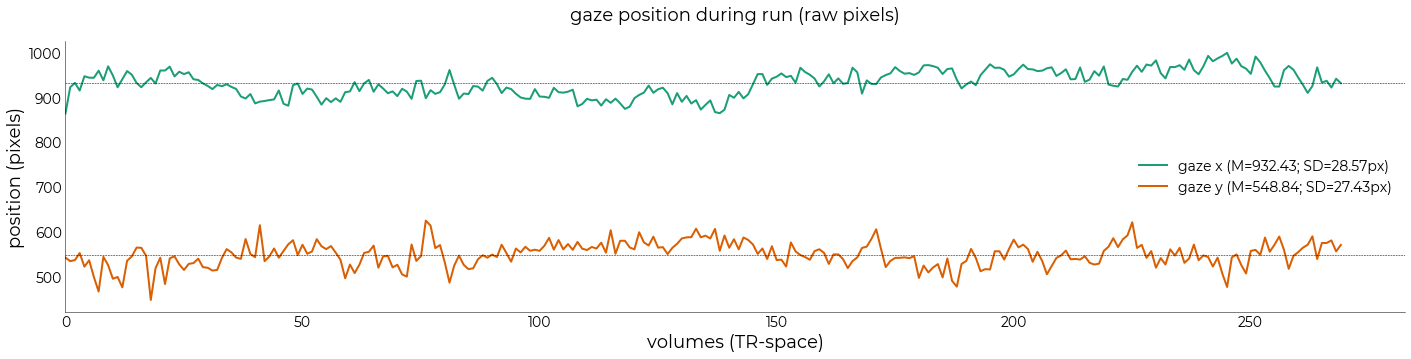

In [44]:
# gaze x/y
df_gaze = eye_.df_space_func.copy()
input_l = [df_gaze[f"gaze_{i}_int"].values for i in ["x","y"]]
avg = [float(input_l[i].mean()) for i in range(len(input_l))]
std = [float(input_l[i].std()) for i in range(len(input_l))]
plotting.LazyPlot(
    input_l,
    line_width=2,
    figsize=(24,5),
    color=["#1B9E77","#D95F02"],
    labels=[f"gaze {i} (M={round(avg[ix],2)}; SD={round(std[ix],2)}px)" for ix,i in enumerate(["x","y"])],
    x_label="volumes (TR-space)",
    y_label="position (pixels)",
    add_hline={"pos": avg},
    title="gaze position during run (raw pixels)"
)

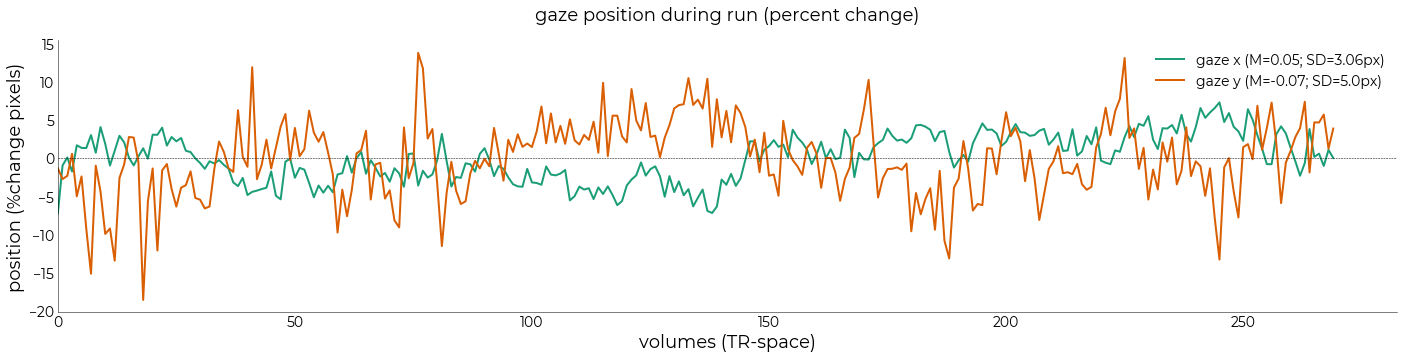

In [43]:
# gaze x/y percent signal changed
input_l = [df_gaze[f"gaze_{i}_int_psc"].values for i in ["x","y"]]
avg = [float(input_l[i].mean()) for i in range(len(input_l))]
std = [float(input_l[i].std()) for i in range(len(input_l))]
plotting.LazyPlot(
    input_l,
    line_width=2,
    figsize=(24,5),
    color=["#1B9E77","#D95F02"],
    labels=[f"gaze {i} (M={round(avg[ix],2)}; SD={round(std[ix],2)}px)" for ix,i in enumerate(["x","y"])],
    x_label="volumes (TR-space)",
    y_label="position (%change pixels)",
    add_hline=0,
    title="gaze position during run (percent change)"
)

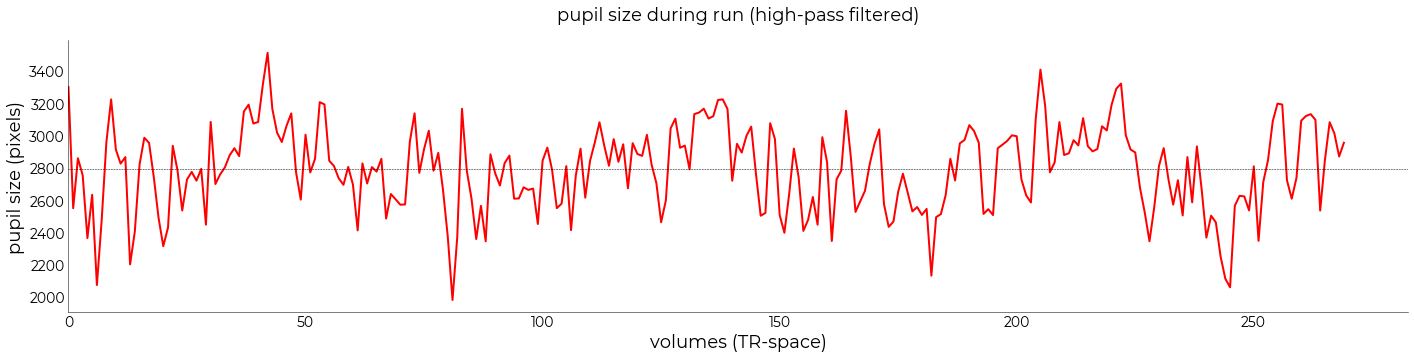

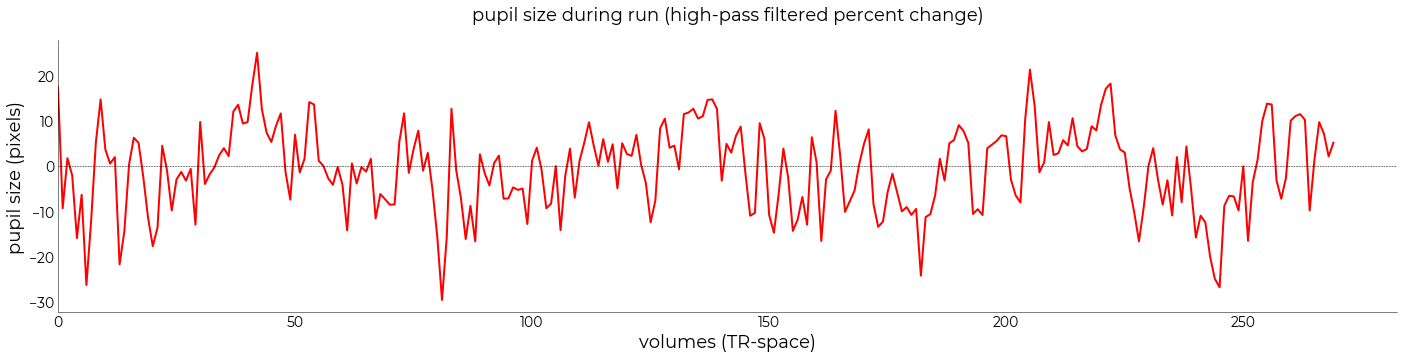

In [18]:
# pupil size
data = df_gaze["pupil_int_hp"].values
avg = data.mean()

# raw-ish values
plotting.LazyPlot(
    data,
    line_width=2,
    figsize=(24,5),
    color="r",
    x_label="volumes (TR-space)",
    y_label="pupil size (pixels)",
    title="pupil size during run (high-pass filtered)",
    add_hline={"pos": avg}
)

# percent change
data = df_gaze["pupil_int_hp_psc"].values
plotting.LazyPlot(
    data,
    line_width=2,
    figsize=(24,5),
    color="r",
    x_label="volumes (TR-space)",
    y_label="pupil size (pixels)",
    title="pupil size during run (high-pass filtered percent change)",
    add_hline=0
)

We can also try to deconvolve the pupil response using the `eye_.df_blinks`-dataframe as onsets, and the pupil size as input data

Selected 'fourier'-basis sets
Adding event 'blink' to model
Fitting with 'ols' minimization
Done


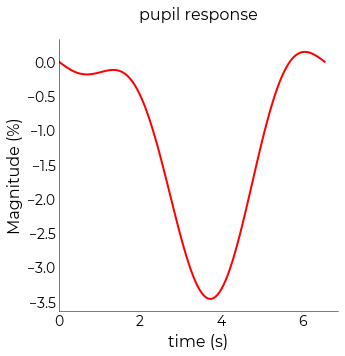

In [42]:
# deconvolve pupil response
interval = [0,7]
nd_pupil = fitting.NideconvFitter(
    df_gaze["pupil_int_hp_psc"],
    eye_.df_blinks,
    basis_sets='fourier',
    n_regressors=4,
    TR=eye_.TR,
    interval=interval,
    add_intercept=True,
    verbose=True)

nd_pupil.plot_average_per_event(
    figsize=(5,5),
    x_label="time (s)",
    y_label="Magnitude (%)",
    title="pupil response",
    line_width=2,
    font_size=16,
    label_size=14,
    color="r")

## Use as part of [ParseExpToolsFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseExpToolsFile) or [ParseFuncFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseFuncFile)

We can also add the `edf`-files into classes that can read in the `tsv`-files from [exptools](https://github.com/Gilles86/exptools2/tree/show_pupil), or that can read in functional files. In case of the latter, we need to realize the inheritance structure from the code.

[Dataset](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#) << [ParseFuncFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseFuncFile) << [ParseExpToolsFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseExpToolsFile) << [ParseEyetrackerFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseEyetrackerFile).

So if we pass the edf-files and tsv-files to [ParseFuncFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseFuncFile), they'll all trickle down where they need to go and you have everything in one dataframe. That would look something like this:

In [47]:
tsv_file = opj(opd(edf_file), "eye.tsv")
exp_ = dataset.ParseExpToolsFile(
    tsv_file, 
    edfs=edf_file,
    use_bids=False, 
    verbose=True, 
    TR=eye_.TR, 
    nr_vols=eye_.nr_vols,
    phase_onset=0)

I was able to import hedfpy

EYETRACKER
Preprocessing /data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.edf
 Alias:        run_1
 Sample rate:  1000
 Start time:   3566804.0
 Stop time:    3863804.0
 Duration:     297.0s [297000 samples]
 Fetching:     ['pupil', 'pupil_int', 'gaze_x_int', 'gaze_y_int', 'gaze_x', 'gaze_y']
 Start time exp =  107.72
 Found 26 blinks [0.09 blinks per second]
 Found 579 saccades
Done

EXPTOOLS
Preprocessing /data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/examples/eye.tsv
 1st 't' @107.72s
 Cutting 107.72s from onsets


You can see that we pass the `edf_file` with the `edfs=`-flag. This will trigger the initialization of [ParseEyetrackerFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseEyetrackerFile), resulting in the same output that we saw before. Because we now also have `tsv_file`, we have some extra output on the preprocessing of that file. We do have, however, our usual output:

In [48]:
exp_.df_blinks.head()

onset
subject run event_type        
1       1   blink        3.298
            blink       11.899
            blink       17.987
            blink       31.194
            blink       43.787

In [49]:
exp_.df_space_func.head()

pupil     pupil_hp  pupil_psc  pupil_hp_psc  pupil_int  \
subject run t                                                              
1       1   0.0  3634.0  3306.871094  29.478714     17.873978     3634.0   
            1.1  2884.0  2557.087891   2.614754     -8.982216     2884.0   
            2.2  3193.0  2866.520752  13.682709      2.101234     3193.0   
            3.3  3087.0  2761.168213   9.885933     -1.672340     3087.0   
            4.4  2697.0  2372.028076  -4.083328    -15.610802     2697.0   

                 pupil_int_hp  pupil_int_psc  pupil_int_hp_psc  gaze_x_int  \
subject run t                                                                
1       1   0.0   3301.236572      29.483154         17.548630  864.299988   
            1.1   2551.462402       2.615150         -9.311279  923.000000   
            2.2   2860.913330      13.684769          1.774490  932.799988   
            3.3   2755.588135       9.887421         -1.998680  915.599976   
            4.4   2366.484131      -4.083939        -15.937943  947.599976   

                 gaze_x_int_hp  ...  gaze_y_int_psc  gaze_y_int_hp_psc  \
subject run t                   ...                                      
1       1   0.0     861.426758  ...       -1.320969           2.517723   
            1.1     920.140625  ...       -2.742149           1.095352   
            2.2     929.968384  ...       -2.323082           1.512039   
            3.3     912.809998  ...        0.555717           4.387268   
            4.4     944.865417  ...       -5.001472          -1.174690   

                     gaze_x   gaze_x_hp  gaze_x_psc  gaze_x_hp_psc  \
subject run t                                                        
1       1   0.0  864.299988  861.372864   -7.246170      -7.759895   
            1.1  923.000000  920.086853   -0.949356      -1.461578   
            2.2  932.799988  929.914856    0.101898      -0.407318   
            3.3  915.599976  912.756775   -1.743164      -2.247887   
            4.4  947.599976  944.812622    1.689514       1.190781   

                     gaze_y   gaze_y_hp  gaze_y_psc  gaze_y_hp_psc  
subject run t                                                       
1       1   0.0  542.000000  559.765381   -1.320480       2.184196  
            1.1  534.200012  551.961243   -2.741142       0.762779  
            2.2  536.500000  554.252808   -2.322235       1.180161  
            3.3  552.299988  570.040222    0.555519       4.055618  
            4.4  521.799988  539.523315   -4.999634      -1.502617  

[5 rows x 24 columns]

As well as the output from [ParseExpToolsFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseExpToolsFile):

In [51]:
exp_.get_onset_df(index=True).head()

onset
subject run event_type           
1       1   baseline     0.002889
            horizontal  20.011666
            horizontal  20.261721
            horizontal  20.511702
            horizontal  20.761743

Similarly, we can do this with the [ParseFuncFile](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#linescanning.dataset.ParseFuncFile) or [Dataset](https://linescanning.readthedocs.io/en/latest/classes/dataset.html#) class:

In [ ]:
obj_ = dataset.Dataset(
    "some_funcfile.nii.gz",
    edf_file=edf_file,
    tsv_file=tsv_file,
    TR=eye_.TR,
    nr_vols=eye_.nr_vols,
    ...
)

---